In [1]:
import numpy as np 
import pandas as pd 
from data_processing import generate_vocab, process_data, create_dataloaders 
from model import get_pretrained_emb, EncoderDecoder, EncoderRNN, DecoderRNN, DecoderSimpleRNN, EncoderSimpleRNN, \
    Attention, DecoderAttnRNN, DecoderRNNV2, EncoderDecoderAttention, EncoderSimpleRNN_Test, DecoderAttnRNN_Test
from train_eval import count_parameters, summarize_results, \
    plot_single_learning_curve, load_experiment_log
from train_eval import train_and_eval, train_and_eval_attn 
import importlib
import pickle as pkl 
import torch

In [2]:
# model identification
MODEL_NAME = 'zh-seq2seq-rnn-attention'
SRC_LANG = 'zh'
TARG_LANG = 'en'

# data processing params  
SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 #30000
TARG_VOCAB_SIZE = 30000 #30000

# model architecture params 
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 2 #2 
ENC_HIDDEN_DIM = 256 #512
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM #2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0.2 # to actually implement
DEC_DROPOUT = 0.2 # to actually implement

# training params  
BATCH_SIZE = 32 #32
NUM_EPOCHS = 200
LR = 0.0005 # 0.0005
OPTIMIZER = 'Adam'
LAZY_TRAIN = True

In [3]:
# store as dict to save to results later 
params = {'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 'rnn_cell_type': RNN_CELL_TYPE, 
          'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 
          'src_vocab_size': SRC_VOCAB_SIZE, 'targ_vocab_size': TARG_VOCAB_SIZE, 
          'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 'dec_hidden_dim': DEC_HIDDEN_DIM,
          'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 'clip_grad_max_norm': CLIP_GRAD_MAX_NORM,
          'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 'learning_rate': LR, 'optimizer': OPTIMIZER, 
          'lazy_train': LAZY_TRAIN} 

In [4]:
#vocab_test = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)

In [5]:
#vocab['zh']['id2token'][987]

In [6]:
#vocab['zh']['token2id']['森林']

In [7]:
#vocab['en']['token2id']['activity']

In [8]:
#vocab['en']['id2token'][987]

In [9]:
# # takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [10]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, vocab)
data_minibatch = process_data(SRC_LANG, TARG_LANG, vocab, sample_limit=BATCH_SIZE) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, vocab, sample_limit=1000)

In [11]:
# # takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab-fake.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [12]:
# vocab_filename = "{}-{}-vocab-fake.p".format(SRC_LANG, TARG_LANG)
# vocab = pkl.load(open(vocab_filename, "rb"))
# data = process_data(SRC_LANG, TARG_LANG, vocab)
# limited_data = process_data(SRC_LANG, TARG_LANG, vocab, sample_limit=BATCH_SIZE) 

In [13]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [14]:
# define model 

# encoder = EncoderRNN(enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, src_max_sentence_len=SRC_MAX_SENTENCE_LEN,
#                      pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
# encoder = EncoderSimpleRNN(enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, src_max_sentence_len=SRC_MAX_SENTENCE_LEN,
#                            pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
# encoder = EncoderSimpleRNN(enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, src_max_sentence_len=SRC_MAX_SENTENCE_LEN,
#                            pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
encoder = EncoderSimpleRNN_Test(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, src_max_sentence_len=SRC_MAX_SENTENCE_LEN,
                                enc_dropout=ENC_DROPOUT, pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

# decoder = DecoderRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS,
#                       targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
#                       pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))

# decoder = DecoderRNNV2(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
#                        targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
#                        pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
# decoder = DecoderSimpleRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
#                            targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
#                            pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
# decoder = DecoderAttnRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
#                          targ_vocab_size=TARG_VOCAB_SIZE, src_max_sentence_len=SRC_MAX_SENTENCE_LEN, 
#                          targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
#                          pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
decoder = DecoderAttnRNN_Test(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                         targ_vocab_size=TARG_VOCAB_SIZE, src_max_sentence_len=SRC_MAX_SENTENCE_LEN, 
                         targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, dec_dropout=DEC_DROPOUT, 
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))


model = EncoderDecoderAttention(encoder, decoder, vocab[TARG_LANG]['token2id']) 

In [15]:
model, results = train_and_eval_attn(
    model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
    params=params, vocab=vocab, print_intermediate=True, save_checkpoint=True, save_to_log=True, 
    lazy_eval=False, inspect_samples=1)

Epoch: 0.00, Train Loss: 10.11, Val Loss: 10.24, Train BLEU: 0.28, Val BLEU: 0.19
Sampling from training predictions...
Source: 这 是 一只 水母 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: here &apos;s a jelly . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> the the the the the the the the the
Attention Weights: tensor([[0.1942, 0.2004, 0.2031, 0.2016, 0.1987, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004],
        [0.1942, 0.2004, 0.2031, 0.2016, 0.1987, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004],
        [0.1942, 0.2004, 0.2031, 0.2016, 0.1988, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004],
        [0.1942, 0.2003, 0.2031, 0.2016, 0.1989, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004],
        [0.1942, 0.2003, 0.2031, 0.2016, 0.1989, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004],
        [0.1942, 0.2004, 0.2031, 0.2016, 0.1988, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004],
        [0.1942, 0.2004, 0.2031, 0.2016, 0.1988, 0.0004, 0.0004, 0.0004, 0.0004,
         0.0004],
       

Epoch: 4.00, Train Loss: 8.31, Val Loss: 9.55, Train BLEU: 0.28, Val BLEU: 0.19
Sampling from training predictions...
Source: 我 真 喜欢 这些 东西 <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: i love that kind of stuff . <EOS> <PAD>
Model: <SOS> the the the the the the the the the
Attention Weights: tensor([[1.6000e-01, 2.2362e-01, 2.2518e-01, 1.9418e-01, 1.3665e-01, 6.0375e-02,
         2.5261e-08, 2.5261e-08, 2.5261e-08, 2.5261e-08],
        [1.6136e-01, 2.2644e-01, 2.2676e-01, 1.9358e-01, 1.3404e-01, 5.7830e-02,
         2.6271e-08, 2.6271e-08, 2.6271e-08, 2.6271e-08],
        [1.6178e-01, 2.2726e-01, 2.2719e-01, 1.9334e-01, 1.3322e-01, 5.7207e-02,
         2.9012e-08, 2.9012e-08, 2.9012e-08, 2.9012e-08],
        [1.6206e-01, 2.2763e-01, 2.2727e-01, 1.9312e-01, 1.3284e-01, 5.7073e-02,
         3.0451e-08, 3.0451e-08, 3.0451e-08, 3.0451e-08],
        [1.6218e-01, 2.2771e-01, 2.2722e-01, 1.9299e-01, 1.3275e-01, 5.7141e-02,
         3.1667e-08, 3.1667e-08, 3.1667e-08, 3.1667e-08],
        [1.6224e-

Epoch: 8.00, Train Loss: 6.35, Val Loss: 8.84, Train BLEU: 0.28, Val BLEU: 0.19
Sampling from training predictions...
Source: 还有 这些 摇晃 着 旋转 转着 的 触角 <EOS> <PAD>
Reference: it &apos;s got tentacles dangling , swirling around like
Model: <SOS> the the the the the the the the the
Attention Weights: tensor([[4.7451e-02, 1.1822e-01, 1.6615e-01, 1.8717e-01, 1.6840e-01, 1.2208e-01,
         1.2361e-01, 5.8105e-02, 8.8227e-03, 2.2466e-10],
        [4.4941e-02, 1.1841e-01, 1.7034e-01, 1.9336e-01, 1.7133e-01, 1.1949e-01,
         1.2145e-01, 5.3369e-02, 7.3171e-03, 5.1302e-10],
        [4.4194e-02, 1.1792e-01, 1.7086e-01, 1.9462e-01, 1.7198e-01, 1.1909e-01,
         1.2129e-01, 5.2788e-02, 7.2469e-03, 6.3946e-10],
        [4.4051e-02, 1.1786e-01, 1.7101e-01, 1.9490e-01, 1.7204e-01, 1.1895e-01,
         1.2121e-01, 5.2709e-02, 7.2741e-03, 6.7713e-10],
        [4.4028e-02, 1.1788e-01, 1.7108e-01, 1.9498e-01, 1.7203e-01, 1.1888e-01,
         1.2115e-01, 5.2680e-02, 7.2854e-03, 6.9433e-10],
        [

Epoch: 12.00, Train Loss: 5.09, Val Loss: 8.64, Train BLEU: 0.28, Val BLEU: 0.19
Sampling from training predictions...
Source: 当 你 站 在 海滩 上 或是 当 你 看到
Reference: part of the problem , i think , is
Model: <SOS> the the the the the the the the the
Attention Weights: tensor([[0.0403, 0.0961, 0.1176, 0.1247, 0.1262, 0.1287, 0.1251, 0.1209, 0.0941,
         0.0264],
        [0.0381, 0.0955, 0.1190, 0.1268, 0.1280, 0.1305, 0.1261, 0.1210, 0.0914,
         0.0235],
        [0.0378, 0.0954, 0.1193, 0.1271, 0.1282, 0.1308, 0.1262, 0.1209, 0.0910,
         0.0233],
        [0.0378, 0.0957, 0.1194, 0.1271, 0.1282, 0.1308, 0.1261, 0.1208, 0.0908,
         0.0233],
        [0.0379, 0.0958, 0.1195, 0.1271, 0.1282, 0.1307, 0.1261, 0.1207, 0.0907,
         0.0233],
        [0.0380, 0.0959, 0.1195, 0.1271, 0.1282, 0.1307, 0.1260, 0.1206, 0.0907,
         0.0233],
        [0.0381, 0.0959, 0.1195, 0.1271, 0.1282, 0.1306, 0.1260, 0.1206, 0.0907,
         0.0233],
        [0.0381, 0.0960, 0.1195, 0.1271, 0.

Epoch: 16.00, Train Loss: 4.48, Val Loss: 8.99, Train BLEU: 0.32, Val BLEU: 0.20
Sampling from training predictions...
Source: 其实 它们 都 是 由 单独 的 动物 结合 合在
Reference: these are all individual animals banding together to make
Model: <SOS> it the the the the the the the the
Attention Weights: tensor([[0.0431, 0.1005, 0.1242, 0.1331, 0.1361, 0.1339, 0.1323, 0.1177, 0.0716,
         0.0077],
        [0.0417, 0.1000, 0.1251, 0.1345, 0.1376, 0.1350, 0.1330, 0.1169, 0.0690,
         0.0071],
        [0.0415, 0.1003, 0.1256, 0.1349, 0.1379, 0.1351, 0.1329, 0.1163, 0.0683,
         0.0072],
        [0.0417, 0.1006, 0.1258, 0.1350, 0.1379, 0.1351, 0.1327, 0.1160, 0.0681,
         0.0072],
        [0.0418, 0.1008, 0.1259, 0.1350, 0.1379, 0.1350, 0.1326, 0.1159, 0.0680,
         0.0072],
        [0.0420, 0.1010, 0.1260, 0.1350, 0.1378, 0.1349, 0.1325, 0.1158, 0.0679,
         0.0072],
        [0.0421, 0.1011, 0.1260, 0.1350, 0.1378, 0.1349, 0.1324, 0.1157, 0.0679,
         0.0072],
        [0.0421, 0

Epoch: 20.00, Train Loss: 4.26, Val Loss: 9.56, Train BLEU: 6.11, Val BLEU: 0.29
Sampling from training predictions...
Source: 大部 大部分 部分 的 动物 也 都 生活 在 海洋
Reference: most of the animals are in the oceans .
Model: <SOS> it the the the the the , , ,
Attention Weights: tensor([[0.0426, 0.0916, 0.1116, 0.1208, 0.1234, 0.1261, 0.1249, 0.1196, 0.1034,
         0.0360],
        [0.0419, 0.0911, 0.1117, 0.1211, 0.1238, 0.1265, 0.1253, 0.1197, 0.1032,
         0.0357],
        [0.0415, 0.0910, 0.1118, 0.1213, 0.1239, 0.1266, 0.1253, 0.1196, 0.1032,
         0.0360],
        [0.0419, 0.0914, 0.1120, 0.1213, 0.1238, 0.1264, 0.1251, 0.1193, 0.1028,
         0.0360],
        [0.0421, 0.0916, 0.1121, 0.1214, 0.1238, 0.1264, 0.1250, 0.1191, 0.1026,
         0.0359],
        [0.0422, 0.0918, 0.1122, 0.1214, 0.1238, 0.1263, 0.1250, 0.1191, 0.1025,
         0.0358],
        [0.0422, 0.0918, 0.1122, 0.1214, 0.1238, 0.1263, 0.1250, 0.1190, 0.1024,
         0.0358],
        [0.0423, 0.0919, 0.1122, 0.1214, 

Epoch: 24.00, Train Loss: 4.18, Val Loss: 10.10, Train BLEU: 7.50, Val BLEU: 1.04
Sampling from training predictions...
Source: 大家 想想 海洋 占 了 地球 球面 面积 的 75
Reference: when you think about it , the oceans are
Model: <SOS> it &apos;s the the the the , , ,
Attention Weights: tensor([[0.0487, 0.0952, 0.1131, 0.1226, 0.1269, 0.1275, 0.1277, 0.1238, 0.0996,
         0.0148],
        [0.0484, 0.0949, 0.1131, 0.1227, 0.1271, 0.1276, 0.1277, 0.1235, 0.0993,
         0.0156],
        [0.0480, 0.0949, 0.1132, 0.1228, 0.1271, 0.1276, 0.1276, 0.1234, 0.0995,
         0.0161],
        [0.0482, 0.0951, 0.1133, 0.1228, 0.1269, 0.1274, 0.1274, 0.1232, 0.0994,
         0.0163],
        [0.0483, 0.0952, 0.1133, 0.1227, 0.1269, 0.1274, 0.1273, 0.1231, 0.0994,
         0.0164],
        [0.0484, 0.0952, 0.1133, 0.1228, 0.1269, 0.1274, 0.1273, 0.1231, 0.0993,
         0.0163],
        [0.0484, 0.0952, 0.1133, 0.1228, 0.1269, 0.1274, 0.1273, 0.1231, 0.0993,
         0.0163],
        [0.0484, 0.0953, 0.1134, 0.

Epoch: 28.00, Train Loss: 4.10, Val Loss: 10.50, Train BLEU: 6.01, Val BLEU: 0.26
Sampling from training predictions...
Source: 海洋 的 平均 深度 是 两英里 英里 <EOS> <PAD> <PAD>
Reference: the average depth is about two miles . <EOS>
Model: <SOS> it &apos;s the the the , , , ,
Attention Weights: tensor([[7.9342e-02, 1.4663e-01, 1.6981e-01, 1.7940e-01, 1.7954e-01, 1.3044e-01,
         1.0812e-01, 6.7136e-03, 2.5560e-12, 2.5560e-12],
        [7.8529e-02, 1.4583e-01, 1.6913e-01, 1.7864e-01, 1.7883e-01, 1.3072e-01,
         1.0989e-01, 8.4387e-03, 2.7912e-11, 2.7912e-11],
        [7.8719e-02, 1.4581e-01, 1.6887e-01, 1.7816e-01, 1.7826e-01, 1.3006e-01,
         1.1085e-01, 9.2698e-03, 5.9222e-11, 5.9222e-11],
        [7.8971e-02, 1.4586e-01, 1.6860e-01, 1.7770e-01, 1.7779e-01, 1.2977e-01,
         1.1156e-01, 9.7346e-03, 7.9431e-11, 7.9431e-11],
        [7.8785e-02, 1.4579e-01, 1.6857e-01, 1.7768e-01, 1.7781e-01, 1.2969e-01,
         1.1189e-01, 9.7719e-03, 7.8683e-11, 7.8683e-11],
        [7.8589e-02,

Epoch: 32.00, Train Loss: 4.02, Val Loss: 10.79, Train BLEU: 5.90, Val BLEU: 0.19
Sampling from training predictions...
Source: 底下 这些 都 是 <UNK> 它们 上上 上上下下 上下 下下
Reference: it &apos;s got these fishing <UNK> on the bottom
Model: <SOS> it &apos;s the the the the the the the
Attention Weights: tensor([[0.0643, 0.1111, 0.1282, 0.1338, 0.1183, 0.1344, 0.1121, 0.1161, 0.0784,
         0.0034],
        [0.0634, 0.1101, 0.1275, 0.1332, 0.1190, 0.1333, 0.1120, 0.1159, 0.0807,
         0.0050],
        [0.0639, 0.1101, 0.1271, 0.1327, 0.1188, 0.1327, 0.1113, 0.1157, 0.0819,
         0.0057],
        [0.0644, 0.1104, 0.1270, 0.1322, 0.1184, 0.1322, 0.1111, 0.1157, 0.0826,
         0.0060],
        [0.0643, 0.1104, 0.1270, 0.1323, 0.1182, 0.1322, 0.1109, 0.1159, 0.0829,
         0.0061],
        [0.0641, 0.1104, 0.1271, 0.1324, 0.1181, 0.1323, 0.1108, 0.1160, 0.0829,
         0.0060],
        [0.0639, 0.1104, 0.1272, 0.1324, 0.1180, 0.1324, 0.1107, 0.1160, 0.0829,
         0.0060],
        [0.0639

Epoch: 36.00, Train Loss: 3.96, Val Loss: 11.00, Train BLEU: 5.89, Val BLEU: 0.19
Sampling from training predictions...
Source: 泰坦 泰坦尼克 泰坦尼克号 坦尼 尼克 号 是 拿 了 不少
Reference: the truth of the matter is that the titanic
Model: <SOS> it the the the the the the the the
Attention Weights: tensor([[0.0536, 0.0855, 0.0989, 0.1118, 0.1245, 0.1270, 0.1249, 0.1201, 0.1059,
         0.0478],
        [0.0545, 0.0838, 0.0974, 0.1103, 0.1234, 0.1262, 0.1245, 0.1203, 0.1073,
         0.0524],
        [0.0554, 0.0839, 0.0973, 0.1097, 0.1226, 0.1252, 0.1237, 0.1197, 0.1076,
         0.0548],
        [0.0562, 0.0846, 0.0978, 0.1099, 0.1220, 0.1244, 0.1228, 0.1190, 0.1074,
         0.0559],
        [0.0563, 0.0846, 0.0977, 0.1097, 0.1219, 0.1242, 0.1227, 0.1190, 0.1076,
         0.0563],
        [0.0560, 0.0844, 0.0975, 0.1096, 0.1220, 0.1244, 0.1229, 0.1192, 0.1078,
         0.0563],
        [0.0557, 0.0842, 0.0973, 0.1095, 0.1221, 0.1246, 0.1230, 0.1193, 0.1079,
         0.0563],
        [0.0556, 0.0841, 0

Epoch: 40.00, Train Loss: 3.90, Val Loss: 11.16, Train BLEU: 6.13, Val BLEU: 0.20
Sampling from training predictions...
Source: 我们 得用 非常 特殊 的 仪器 才能 能到 到达 那个
Reference: we have to have a very special technology to
Model: <SOS> it of the the the the the the the
Attention Weights: tensor([[0.0583, 0.0913, 0.1138, 0.1209, 0.1243, 0.1233, 0.1198, 0.0996, 0.1019,
         0.0467],
        [0.0589, 0.0908, 0.1120, 0.1190, 0.1223, 0.1217, 0.1188, 0.1015, 0.1030,
         0.0519],
        [0.0605, 0.0917, 0.1115, 0.1178, 0.1208, 0.1202, 0.1175, 0.1014, 0.1035,
         0.0552],
        [0.0615, 0.0923, 0.1112, 0.1172, 0.1200, 0.1194, 0.1169, 0.1015, 0.1036,
         0.0566],
        [0.0616, 0.0923, 0.1111, 0.1170, 0.1197, 0.1192, 0.1167, 0.1015, 0.1037,
         0.0571],
        [0.0613, 0.0921, 0.1111, 0.1171, 0.1199, 0.1193, 0.1168, 0.1015, 0.1038,
         0.0570],
        [0.0611, 0.0920, 0.1112, 0.1172, 0.1200, 0.1194, 0.1169, 0.1014, 0.1039,
         0.0570],
        [0.0609, 0.0919, 0.1

Epoch: 44.00, Train Loss: 3.83, Val Loss: 11.27, Train BLEU: 6.34, Val BLEU: 0.20
Sampling from training predictions...
Source: 这儿 基本 基本上 都 没有 被 开发 发过 但是 像
Reference: it &apos;s mostly unexplored , and yet there are
Model: <SOS> most of the the the the the the the
Attention Weights: tensor([[0.0602, 0.0962, 0.1081, 0.1158, 0.1182, 0.1193, 0.1169, 0.1124, 0.0991,
         0.0537],
        [0.0613, 0.0957, 0.1072, 0.1144, 0.1168, 0.1178, 0.1157, 0.1119, 0.1003,
         0.0590],
        [0.0633, 0.0959, 0.1066, 0.1131, 0.1153, 0.1163, 0.1145, 0.1112, 0.1009,
         0.0630],
        [0.0645, 0.0962, 0.1064, 0.1125, 0.1146, 0.1155, 0.1138, 0.1108, 0.1011,
         0.0646],
        [0.0649, 0.0962, 0.1063, 0.1122, 0.1143, 0.1152, 0.1136, 0.1107, 0.1013,
         0.0654],
        [0.0646, 0.0961, 0.1063, 0.1123, 0.1143, 0.1152, 0.1137, 0.1107, 0.1014,
         0.0654],
        [0.0643, 0.0961, 0.1063, 0.1123, 0.1144, 0.1153, 0.1137, 0.1108, 0.1014,
         0.0654],
        [0.0642, 0.0961

Epoch: 48.00, Train Loss: 3.77, Val Loss: 11.35, Train BLEU: 6.89, Val BLEU: 0.24
Sampling from training predictions...
Source: 我们 将 用 一些 影片 来讲 讲述 一些 深海 海里
Reference: and we &apos;re going to tell you some stories
Model: <SOS> we of the the the the the the the
Attention Weights: tensor([[0.0643, 0.1001, 0.1104, 0.1150, 0.1177, 0.1182, 0.1165, 0.1119, 0.0984,
         0.0476],
        [0.0658, 0.0998, 0.1095, 0.1136, 0.1159, 0.1164, 0.1149, 0.1109, 0.0992,
         0.0539],
        [0.0683, 0.0995, 0.1083, 0.1121, 0.1142, 0.1147, 0.1135, 0.1101, 0.1001,
         0.0591],
        [0.0699, 0.0996, 0.1078, 0.1114, 0.1134, 0.1138, 0.1127, 0.1097, 0.1004,
         0.0614],
        [0.0703, 0.0995, 0.1076, 0.1111, 0.1130, 0.1135, 0.1125, 0.1095, 0.1006,
         0.0624],
        [0.0702, 0.0994, 0.1075, 0.1110, 0.1130, 0.1135, 0.1125, 0.1096, 0.1008,
         0.0625],
        [0.0700, 0.0994, 0.1075, 0.1110, 0.1130, 0.1135, 0.1126, 0.1096, 0.1008,
         0.0625],
        [0.0698, 0.0994, 0.

Epoch: 52.00, Train Loss: 3.69, Val Loss: 11.40, Train BLEU: 7.09, Val BLEU: 0.25
Sampling from training predictions...
Source: 我 真 喜欢 这些 东西 <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: i love that kind of stuff . <EOS> <PAD>
Model: <SOS> it &apos;s the the , <EOS> <EOS> <EOS> <EOS>
Attention Weights: tensor([[1.5984e-01, 2.2995e-01, 2.4014e-01, 2.2372e-01, 1.4411e-01, 2.2454e-03,
         1.1927e-12, 1.1927e-12, 1.1927e-12, 1.1927e-12],
        [1.5902e-01, 2.2647e-01, 2.3600e-01, 2.2134e-01, 1.5188e-01, 5.2992e-03,
         2.6446e-11, 2.6446e-11, 2.6446e-11, 2.6446e-11],
        [1.6063e-01, 2.2149e-01, 2.3086e-01, 2.1923e-01, 1.5901e-01, 8.7832e-03,
         8.5534e-11, 8.5534e-11, 8.5534e-11, 8.5534e-11],
        [1.6310e-01, 2.1834e-01, 2.2688e-01, 2.1693e-01, 1.6288e-01, 1.1871e-02,
         1.4949e-10, 1.4949e-10, 1.4949e-10, 1.4949e-10],
        [1.6361e-01, 2.1725e-01, 2.2557e-01, 2.1618e-01, 1.6443e-01, 1.2973e-02,
         1.5633e-10, 1.5633e-10, 1.5633e-10, 1.5633e-10],
      

Epoch: 56.00, Train Loss: 3.62, Val Loss: 11.46, Train BLEU: 7.12, Val BLEU: 0.30
Sampling from training predictions...
Source: 这 是 一种 种群 栖 动物 <EOS> <PAD> <PAD> <PAD>
Reference: it &apos;s a colonial animal . <EOS> <PAD> <PAD>
Model: <SOS> it &apos;s the the . <EOS> <EOS> <EOS> <EOS>
Attention Weights: tensor([[1.2428e-01, 1.8626e-01, 1.9932e-01, 1.9752e-01, 1.7952e-01, 1.1178e-01,
         1.3155e-03, 8.3292e-13, 8.3292e-13, 8.3292e-13],
        [1.2510e-01, 1.8510e-01, 1.9662e-01, 1.9433e-01, 1.7818e-01, 1.1752e-01,
         3.1443e-03, 1.9546e-11, 1.9546e-11, 1.9546e-11],
        [1.2769e-01, 1.8136e-01, 1.9197e-01, 1.9060e-01, 1.7750e-01, 1.2502e-01,
         5.8487e-03, 7.0047e-11, 7.0047e-11, 7.0047e-11],
        [1.3133e-01, 1.7888e-01, 1.8823e-01, 1.8721e-01, 1.7600e-01, 1.2964e-01,
         8.7106e-03, 1.2819e-10, 1.2819e-10, 1.2819e-10],
        [1.3245e-01, 1.7777e-01, 1.8667e-01, 1.8580e-01, 1.7537e-01, 1.3185e-01,
         1.0080e-02, 1.3816e-10, 1.3816e-10, 1.3816e-10],
 

Epoch: 60.00, Train Loss: 3.53, Val Loss: 11.52, Train BLEU: 7.17, Val BLEU: 0.28
Sampling from training predictions...
Source: 和 我们 合作 的 人们 帮 我们 找到 了 新
Reference: people that have partnered with us have given us
Model: <SOS> we of the the the the the the the
Attention Weights: tensor([[0.0664, 0.1045, 0.1148, 0.1179, 0.1179, 0.1160, 0.1124, 0.1060, 0.0926,
         0.0515],
        [0.0698, 0.1052, 0.1139, 0.1162, 0.1157, 0.1139, 0.1104, 0.1046, 0.0933,
         0.0570],
        [0.0733, 0.1043, 0.1117, 0.1137, 0.1133, 0.1118, 0.1089, 0.1042, 0.0951,
         0.0637],
        [0.0764, 0.1040, 0.1105, 0.1122, 0.1119, 0.1104, 0.1080, 0.1038, 0.0957,
         0.0672],
        [0.0777, 0.1037, 0.1099, 0.1115, 0.1112, 0.1098, 0.1075, 0.1036, 0.0961,
         0.0692],
        [0.0778, 0.1035, 0.1096, 0.1112, 0.1110, 0.1097, 0.1074, 0.1036, 0.0963,
         0.0699],
        [0.0778, 0.1034, 0.1095, 0.1111, 0.1109, 0.1096, 0.1074, 0.1037, 0.0964,
         0.0702],
        [0.0778, 0.1033, 0.1

Epoch: 64.00, Train Loss: 3.45, Val Loss: 11.57, Train BLEU: 7.06, Val BLEU: 0.27
Sampling from training predictions...
Source: 我们 这 有 不少 精彩 的 泰坦 泰坦尼克 坦尼 尼克
Reference: we &apos;ve got some of the most incredible video
Model: <SOS> we of the the the the the the the
Attention Weights: tensor([[0.0694, 0.1157, 0.1263, 0.1298, 0.1303, 0.1274, 0.1194, 0.0762, 0.0627,
         0.0429],
        [0.0722, 0.1157, 0.1250, 0.1274, 0.1274, 0.1248, 0.1175, 0.0771, 0.0649,
         0.0481],
        [0.0761, 0.1137, 0.1217, 0.1237, 0.1236, 0.1216, 0.1156, 0.0799, 0.0691,
         0.0551],
        [0.0792, 0.1119, 0.1188, 0.1206, 0.1206, 0.1189, 0.1140, 0.0833, 0.0731,
         0.0596],
        [0.0804, 0.1110, 0.1175, 0.1192, 0.1193, 0.1177, 0.1133, 0.0849, 0.0749,
         0.0619],
        [0.0806, 0.1106, 0.1169, 0.1187, 0.1188, 0.1173, 0.1132, 0.0854, 0.0756,
         0.0629],
        [0.0805, 0.1103, 0.1166, 0.1184, 0.1185, 0.1171, 0.1131, 0.0858, 0.0761,
         0.0635],
        [0.0804, 0.1100

Epoch: 68.00, Train Loss: 3.37, Val Loss: 11.60, Train BLEU: 7.29, Val BLEU: 0.27
Sampling from training predictions...
Source: 我 真 喜欢 这些 东西 <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: i love that kind of stuff . <EOS> <PAD>
Model: <SOS> it &apos;s the the to <EOS> <EOS> <EOS> <EOS>
Attention Weights: tensor([[1.6016e-01, 2.4557e-01, 2.4882e-01, 2.1814e-01, 1.2635e-01, 9.5458e-04,
         1.3346e-12, 1.3346e-12, 1.3346e-12, 1.3346e-12],
        [1.5887e-01, 2.4541e-01, 2.4742e-01, 2.1699e-01, 1.2955e-01, 1.7643e-03,
         2.5161e-11, 2.5161e-11, 2.5161e-11, 2.5161e-11],
        [1.6261e-01, 2.3886e-01, 2.4106e-01, 2.1537e-01, 1.3847e-01, 3.6264e-03,
         9.7127e-11, 9.7127e-11, 9.7127e-11, 9.7127e-11],
        [1.6847e-01, 2.3168e-01, 2.3347e-01, 2.1236e-01, 1.4691e-01, 7.1099e-03,
         1.9939e-10, 1.9939e-10, 1.9939e-10, 1.9939e-10],
        [1.7021e-01, 2.2802e-01, 2.2987e-01, 2.1102e-01, 1.5141e-01, 9.4721e-03,
         2.2271e-10, 2.2271e-10, 2.2271e-10, 2.2271e-10],
     

Epoch: 72.00, Train Loss: 3.28, Val Loss: 11.65, Train BLEU: 7.74, Val BLEU: 0.29
Sampling from training predictions...
Source: 地球 的 大部 大部分 部分 都 是 海水 <EOS> <PAD>
Reference: most of the planet is ocean water . <EOS>
Model: <SOS> it &apos;s the to . <EOS> <EOS> <EOS> <EOS>
Attention Weights: tensor([[9.0671e-02, 1.4514e-01, 1.5504e-01, 1.5599e-01, 1.4684e-01, 1.3233e-01,
         1.1091e-01, 6.2577e-02, 5.0479e-04, 8.2600e-13],
        [8.9112e-02, 1.4722e-01, 1.5627e-01, 1.5521e-01, 1.4591e-01, 1.3171e-01,
         1.1053e-01, 6.3230e-02, 8.1249e-04, 1.3809e-11],
        [9.3583e-02, 1.4552e-01, 1.5320e-01, 1.5179e-01, 1.4321e-01, 1.3063e-01,
         1.1188e-01, 6.8557e-02, 1.6340e-03, 5.6132e-11],
        [9.9288e-02, 1.4273e-01, 1.4884e-01, 1.4745e-01, 1.4013e-01, 1.2949e-01,
         1.1352e-01, 7.5221e-02, 3.3373e-03, 1.2307e-10],
        [1.0144e-01, 1.4078e-01, 1.4633e-01, 1.4516e-01, 1.3854e-01, 1.2896e-01,
         1.1460e-01, 7.9459e-02, 4.7239e-03, 1.3786e-10],
        [1.018

Epoch: 76.00, Train Loss: 3.19, Val Loss: 11.71, Train BLEU: 8.45, Val BLEU: 0.27
Sampling from training predictions...
Source: 底下 这些 都 是 <UNK> 它们 上上 上上下下 上下 下下
Reference: it &apos;s got these fishing <UNK> on the bottom
Model: <SOS> it &apos;s got to to , <EOS> <EOS> <EOS>
Attention Weights: tensor([[0.1064, 0.1585, 0.1476, 0.1092, 0.0054, 0.1809, 0.0599, 0.1580, 0.0740,
         0.0001],
        [0.1065, 0.1677, 0.1576, 0.1165, 0.0062, 0.1758, 0.0557, 0.1450, 0.0689,
         0.0001],
        [0.1110, 0.1656, 0.1573, 0.1214, 0.0097, 0.1684, 0.0605, 0.1361, 0.0698,
         0.0003],
        [0.1158, 0.1602, 0.1534, 0.1238, 0.0151, 0.1596, 0.0673, 0.1304, 0.0735,
         0.0008],
        [0.1167, 0.1555, 0.1498, 0.1244, 0.0196, 0.1544, 0.0724, 0.1284, 0.0776,
         0.0012],
        [0.1166, 0.1528, 0.1476, 0.1240, 0.0218, 0.1516, 0.0746, 0.1285, 0.0809,
         0.0015],
        [0.1158, 0.1509, 0.1461, 0.1234, 0.0231, 0.1505, 0.0757, 0.1294, 0.0835,
         0.0017],
        [0.11

Epoch: 80.00, Train Loss: 3.10, Val Loss: 11.76, Train BLEU: 9.65, Val BLEU: 0.29
Sampling from training predictions...
Source: 是 我 最 喜欢 的 因为 它 哪 都 能动
Reference: it &apos;s one of my favorites , because it
Model: <SOS> it &apos;s &apos;s to , , . . .
Attention Weights: tensor([[0.0814, 0.1195, 0.1289, 0.1364, 0.1335, 0.1300, 0.1164, 0.0983, 0.0556,
         0.0001],
        [0.0809, 0.1228, 0.1319, 0.1379, 0.1341, 0.1291, 0.1146, 0.0954, 0.0531,
         0.0001],
        [0.0866, 0.1232, 0.1309, 0.1356, 0.1316, 0.1267, 0.1132, 0.0957, 0.0563,
         0.0003],
        [0.0927, 0.1226, 0.1285, 0.1323, 0.1284, 0.1241, 0.1122, 0.0969, 0.0614,
         0.0008],
        [0.0953, 0.1215, 0.1265, 0.1297, 0.1263, 0.1225, 0.1120, 0.0986, 0.0663,
         0.0013],
        [0.0957, 0.1206, 0.1254, 0.1284, 0.1253, 0.1218, 0.1122, 0.0999, 0.0692,
         0.0016],
        [0.0957, 0.1199, 0.1245, 0.1274, 0.1246, 0.1214, 0.1124, 0.1008, 0.0715,
         0.0019],
        [0.0958, 0.1194, 0.1240, 0.12

Epoch: 84.00, Train Loss: 3.01, Val Loss: 11.82, Train BLEU: 9.84, Val BLEU: 0.33
Sampling from training predictions...
Source: 但 我 想 告诉 你 的 是 当 你 站
Reference: but when you &apos;re standing at the beach ,
Model: <SOS> we of the the , , the the the
Attention Weights: tensor([[0.0736, 0.1090, 0.1173, 0.1241, 0.1208, 0.1201, 0.1129, 0.1003, 0.0811,
         0.0408],
        [0.0785, 0.1114, 0.1182, 0.1232, 0.1194, 0.1179, 0.1106, 0.0984, 0.0801,
         0.0422],
        [0.0863, 0.1106, 0.1154, 0.1194, 0.1157, 0.1144, 0.1083, 0.0981, 0.0828,
         0.0489],
        [0.0904, 0.1095, 0.1130, 0.1161, 0.1130, 0.1119, 0.1069, 0.0984, 0.0856,
         0.0552],
        [0.0910, 0.1086, 0.1119, 0.1148, 0.1119, 0.1110, 0.1065, 0.0988, 0.0871,
         0.0585],
        [0.0908, 0.1080, 0.1113, 0.1141, 0.1114, 0.1107, 0.1064, 0.0991, 0.0880,
         0.0603],
        [0.0907, 0.1077, 0.1110, 0.1137, 0.1111, 0.1104, 0.1063, 0.0992, 0.0885,
         0.0613],
        [0.0907, 0.1075, 0.1107, 0.1134

Epoch: 88.00, Train Loss: 2.92, Val Loss: 11.88, Train BLEU: 10.11, Val BLEU: 0.31
Sampling from training predictions...
Source: 我们 用 的 是 深海 潜水 潜水艇 <UNK> 号 和
Reference: we use the submarine alvin and we use cameras
Model: <SOS> we of the the the the the the the
Attention Weights: tensor([[0.1099, 0.1661, 0.1697, 0.1569, 0.1395, 0.0722, 0.0016, 0.0009, 0.1278,
         0.0554],
        [0.1189, 0.1658, 0.1673, 0.1557, 0.1394, 0.0800, 0.0036, 0.0025, 0.1133,
         0.0534],
        [0.1259, 0.1567, 0.1574, 0.1493, 0.1388, 0.0906, 0.0083, 0.0064, 0.1088,
         0.0578],
        [0.1263, 0.1491, 0.1496, 0.1437, 0.1368, 0.0980, 0.0140, 0.0112, 0.1075,
         0.0637],
        [0.1251, 0.1455, 0.1463, 0.1414, 0.1363, 0.1011, 0.0169, 0.0137, 0.1070,
         0.0666],
        [0.1243, 0.1439, 0.1449, 0.1404, 0.1354, 0.1020, 0.0183, 0.0150, 0.1072,
         0.0689],
        [0.1233, 0.1425, 0.1435, 0.1392, 0.1342, 0.1025, 0.0194, 0.0161, 0.1081,
         0.0713],
        [0.1226, 0.1417, 0

Epoch: 92.00, Train Loss: 2.82, Val Loss: 11.92, Train BLEU: 13.25, Val BLEU: 0.30
Sampling from training predictions...
Source: 大卫 <UNK> 这位 是 比尔 <UNK> 我 是 大卫 <UNK>
Reference: this is bill lange . i &apos;m dave gallo
Model: <SOS> this is bill lange , , , , ,
Attention Weights: tensor([[0.0254, 0.0018, 0.2376, 0.1621, 0.0150, 0.0022, 0.3081, 0.1886, 0.0590,
         0.0001],
        [0.0354, 0.0031, 0.2496, 0.1727, 0.0182, 0.0036, 0.2857, 0.1739, 0.0576,
         0.0002],
        [0.0547, 0.0087, 0.2467, 0.1752, 0.0316, 0.0095, 0.2495, 0.1581, 0.0649,
         0.0010],
        [0.0699, 0.0163, 0.2290, 0.1725, 0.0452, 0.0173, 0.2207, 0.1514, 0.0750,
         0.0026],
        [0.0771, 0.0216, 0.2143, 0.1686, 0.0538, 0.0228, 0.2061, 0.1496, 0.0819,
         0.0040],
        [0.0805, 0.0251, 0.2029, 0.1653, 0.0589, 0.0266, 0.1975, 0.1499, 0.0879,
         0.0054],
        [0.0817, 0.0267, 0.1978, 0.1638, 0.0610, 0.0284, 0.1937, 0.1499, 0.0908,
         0.0061],
        [0.0826, 0.0276, 0.1

Epoch: 96.00, Train Loss: 2.73, Val Loss: 11.97, Train BLEU: 13.88, Val BLEU: 0.28
Sampling from training predictions...
Source: 是 我 最 喜欢 的 因为 它 哪 都 能动
Reference: it &apos;s one of my favorites , because it
Model: <SOS> it &apos;s one to , , , , <EOS>
Attention Weights: tensor([[0.0820, 0.1232, 0.1321, 0.1426, 0.1386, 0.1369, 0.1138, 0.0893, 0.0416,
         0.0000],
        [0.0898, 0.1272, 0.1339, 0.1427, 0.1369, 0.1344, 0.1100, 0.0851, 0.0400,
         0.0001],
        [0.1029, 0.1273, 0.1309, 0.1379, 0.1319, 0.1299, 0.1078, 0.0861, 0.0451,
         0.0003],
        [0.1102, 0.1251, 0.1268, 0.1324, 0.1271, 0.1259, 0.1076, 0.0898, 0.0540,
         0.0011],
        [0.1108, 0.1229, 0.1244, 0.1292, 0.1248, 0.1241, 0.1083, 0.0930, 0.0605,
         0.0020],
        [0.1100, 0.1214, 0.1230, 0.1274, 0.1237, 0.1231, 0.1091, 0.0953, 0.0644,
         0.0025],
        [0.1089, 0.1205, 0.1221, 0.1260, 0.1229, 0.1223, 0.1098, 0.0970, 0.0675,
         0.0030],
        [0.1086, 0.1198, 0.1213, 0.1

Epoch: 100.00, Train Loss: 2.63, Val Loss: 12.02, Train BLEU: 14.04, Val BLEU: 0.30
Sampling from training predictions...
Source: 原来 它 是 海洋 洋中 最长 的 生物 <EOS> <PAD>
Reference: this turns out to be the longest creature in
Model: <SOS> it &apos;s a to about . <EOS> <EOS> <EOS>
Attention Weights: tensor([[1.3990e-01, 2.0174e-01, 1.8730e-01, 1.7837e-01, 3.0431e-02, 1.2862e-01,
         8.5545e-02, 4.7682e-02, 4.1929e-04, 2.5043e-12],
        [1.5692e-01, 2.0531e-01, 1.8713e-01, 1.7629e-01, 3.8932e-02, 1.1362e-01,
         7.6886e-02, 4.4077e-02, 8.3468e-04, 3.6580e-11],
        [1.7153e-01, 1.9225e-01, 1.7522e-01, 1.7132e-01, 6.1266e-02, 1.0456e-01,
         7.4336e-02, 4.7225e-02, 2.2960e-03, 1.8776e-10],
        [1.6821e-01, 1.7743e-01, 1.6481e-01, 1.6741e-01, 8.2842e-02, 1.0276e-01,
         7.7255e-02, 5.4052e-02, 5.2316e-03, 6.0303e-10],
        [1.6395e-01, 1.7188e-01, 1.6142e-01, 1.6591e-01, 8.9998e-02, 1.0278e-01,
         7.9513e-02, 5.7727e-02, 6.8238e-03, 7.2021e-10],
        [1.5

Epoch: 103.00, Train Loss: 2.56, Val Loss: 12.07, Train BLEU: 14.91, Val BLEU: 0.31
Sampling from training predictions...
Source: 大多 大多数 多数 地震 和 火山 喷发 也 都 发生
Reference: most of the earthquakes and volcanoes are in the
Model: <SOS> most of the the the the the the the
Attention Weights: tensor([[0.0380, 0.0121, 0.1443, 0.1431, 0.1325, 0.1535, 0.1434, 0.1076, 0.0838,
         0.0419],
        [0.0642, 0.0336, 0.1409, 0.1340, 0.1246, 0.1401, 0.1314, 0.1018, 0.0819,
         0.0475],
        [0.0880, 0.0627, 0.1317, 0.1218, 0.1139, 0.1262, 0.1198, 0.0969, 0.0824,
         0.0566],
        [0.0957, 0.0770, 0.1248, 0.1153, 0.1086, 0.1197, 0.1151, 0.0958, 0.0842,
         0.0639],
        [0.0970, 0.0809, 0.1211, 0.1128, 0.1069, 0.1176, 0.1136, 0.0960, 0.0859,
         0.0682],
        [0.0973, 0.0824, 0.1190, 0.1114, 0.1062, 0.1159, 0.1125, 0.0968, 0.0876,
         0.0709],
        [0.0972, 0.0833, 0.1177, 0.1106, 0.1058, 0.1148, 0.1117, 0.0974, 0.0889,
         0.0727],
        [0.0967, 0.08

Epoch: 107.00, Train Loss: 2.46, Val Loss: 12.12, Train BLEU: 18.45, Val BLEU: 0.30
Sampling from training predictions...
Source: 大卫 <UNK> 这位 是 比尔 <UNK> 我 是 大卫 <UNK>
Reference: this is bill lange . i &apos;m dave gallo
Model: <SOS> this is bill lange , , . . .
Attention Weights: tensor([[0.0291, 0.0023, 0.2015, 0.1610, 0.0102, 0.0025, 0.3287, 0.2146, 0.0499,
         0.0001],
        [0.0451, 0.0061, 0.2220, 0.1697, 0.0175, 0.0066, 0.2935, 0.1871, 0.0517,
         0.0005],
        [0.0724, 0.0206, 0.2226, 0.1657, 0.0381, 0.0216, 0.2392, 0.1564, 0.0607,
         0.0027],
        [0.0867, 0.0351, 0.2048, 0.1567, 0.0547, 0.0364, 0.2061, 0.1434, 0.0694,
         0.0067],
        [0.0906, 0.0431, 0.1943, 0.1517, 0.0625, 0.0444, 0.1924, 0.1385, 0.0731,
         0.0094],
        [0.0932, 0.0486, 0.1847, 0.1484, 0.0677, 0.0499, 0.1813, 0.1363, 0.0780,
         0.0120],
        [0.0945, 0.0511, 0.1793, 0.1466, 0.0702, 0.0526, 0.1756, 0.1352, 0.0812,
         0.0137],
        [0.0953, 0.0525, 0.

Epoch: 111.00, Train Loss: 2.36, Val Loss: 12.17, Train BLEU: 22.26, Val BLEU: 0.31
Sampling from training predictions...
Source: 原来 它 是 海洋 洋中 最长 的 生物 <EOS> <PAD>
Reference: this turns out to be the longest creature in
Model: <SOS> it &apos;s a to about . <EOS> <EOS> <EOS>
Attention Weights: tensor([[1.5512e-01, 2.2733e-01, 2.0128e-01, 1.9020e-01, 1.4297e-02, 1.0399e-01,
         7.0042e-02, 3.7352e-02, 3.9637e-04, 4.0020e-12],
        [1.7475e-01, 2.2396e-01, 1.9591e-01, 1.8206e-01, 2.4607e-02, 9.5921e-02,
         6.5724e-02, 3.6196e-02, 8.7942e-04, 5.0780e-11],
        [1.8969e-01, 2.0340e-01, 1.7744e-01, 1.7337e-01, 5.2681e-02, 9.4332e-02,
         6.5950e-02, 4.0383e-02, 2.7467e-03, 2.7785e-10],
        [1.8259e-01, 1.8140e-01, 1.6302e-01, 1.7033e-01, 8.4995e-02, 9.3622e-02,
         6.9060e-02, 4.8136e-02, 6.8541e-03, 1.3084e-09],
        [1.7792e-01, 1.7501e-01, 1.5944e-01, 1.7006e-01, 9.5113e-02, 9.2576e-02,
         7.0091e-02, 5.1066e-02, 8.7222e-03, 1.7956e-09],
        [1.7

Epoch: 115.00, Train Loss: 2.28, Val Loss: 12.22, Train BLEU: 24.70, Val BLEU: 0.30
Sampling from training predictions...
Source: 是 我 最 喜欢 的 因为 它 哪 都 能动
Reference: it &apos;s one of my favorites , because it
Model: <SOS> it &apos;s one of my , , , ,
Attention Weights: tensor([[0.0897, 0.1294, 0.1332, 0.1414, 0.1379, 0.1423, 0.1097, 0.0831, 0.0333,
         0.0000],
        [0.1047, 0.1328, 0.1337, 0.1387, 0.1337, 0.1373, 0.1055, 0.0797, 0.0338,
         0.0001],
        [0.1251, 0.1338, 0.1297, 0.1316, 0.1259, 0.1299, 0.1021, 0.0807, 0.0406,
         0.0007],
        [0.1314, 0.1290, 0.1244, 0.1264, 0.1211, 0.1265, 0.1022, 0.0852, 0.0509,
         0.0029],
        [0.1313, 0.1261, 0.1220, 0.1241, 0.1193, 0.1251, 0.1028, 0.0879, 0.0567,
         0.0048],
        [0.1305, 0.1243, 0.1206, 0.1229, 0.1184, 0.1246, 0.1032, 0.0894, 0.0600,
         0.0062],
        [0.1281, 0.1228, 0.1197, 0.1222, 0.1181, 0.1242, 0.1041, 0.0911, 0.0629,
         0.0069],
        [0.1268, 0.1216, 0.1188, 0.121

Epoch: 119.00, Train Loss: 2.17, Val Loss: 12.25, Train BLEU: 25.01, Val BLEU: 0.30
Sampling from training predictions...
Source: 还有 这些 摇晃 着 旋转 转着 的 触角 <EOS> <PAD>
Reference: it &apos;s got tentacles dangling , swirling around like
Model: <SOS> it &apos;s got tentacles dangling . . <EOS> <EOS>
Attention Weights: tensor([[1.3157e-01, 2.0206e-01, 2.1508e-01, 2.0003e-01, 1.9905e-01, 1.2100e-02,
         2.8195e-02, 1.1768e-02, 1.4842e-04, 4.4513e-12],
        [1.5714e-01, 1.9951e-01, 2.0235e-01, 1.8602e-01, 1.8833e-01, 2.1618e-02,
         3.0301e-02, 1.4248e-02, 4.8470e-04, 4.9025e-11],
        [1.8144e-01, 1.8897e-01, 1.8204e-01, 1.6769e-01, 1.7609e-01, 4.5111e-02,
         3.7235e-02, 1.9658e-02, 1.7548e-03, 2.4427e-10],
        [1.7842e-01, 1.6968e-01, 1.6436e-01, 1.5501e-01, 1.7330e-01, 8.0559e-02,
         4.5700e-02, 2.7719e-02, 5.2579e-03, 1.6210e-09],
        [1.7392e-01, 1.6263e-01, 1.5910e-01, 1.5084e-01, 1.7352e-01, 9.4533e-02,
         4.8102e-02, 3.0465e-02, 6.8881e-03, 2.75

Epoch: 123.00, Train Loss: 2.07, Val Loss: 12.30, Train BLEU: 28.40, Val BLEU: 0.29
Sampling from training predictions...
Source: 当 你 站 在 海滩 上 或是 当 你 看到
Reference: part of the problem , i think , is
Model: <SOS> and of the the , , the the the
Attention Weights: tensor([[0.0808, 0.1041, 0.1029, 0.1076, 0.1547, 0.1088, 0.1499, 0.0853, 0.0665,
         0.0394],
        [0.1050, 0.1087, 0.1032, 0.1044, 0.1421, 0.1029, 0.1383, 0.0834, 0.0666,
         0.0455],
        [0.1242, 0.1095, 0.1005, 0.0993, 0.1297, 0.0969, 0.1272, 0.0831, 0.0709,
         0.0587],
        [0.1238, 0.1059, 0.0982, 0.0975, 0.1240, 0.0954, 0.1228, 0.0848, 0.0757,
         0.0720],
        [0.1217, 0.1042, 0.0975, 0.0970, 0.1223, 0.0952, 0.1217, 0.0857, 0.0776,
         0.0771],
        [0.1205, 0.1032, 0.0972, 0.0971, 0.1223, 0.0954, 0.1218, 0.0860, 0.0781,
         0.0785],
        [0.1186, 0.1022, 0.0971, 0.0972, 0.1215, 0.0958, 0.1212, 0.0868, 0.0793,
         0.0804],
        [0.1171, 0.1016, 0.0969, 0.0972, 0.12

Epoch: 127.00, Train Loss: 1.98, Val Loss: 12.34, Train BLEU: 30.49, Val BLEU: 0.32
Sampling from training predictions...
Source: 我们 用 的 是 深海 潜水 潜水艇 <UNK> 号 和
Reference: we use the submarine alvin and we use cameras
Model: <SOS> we use the the alvin , the the the
Attention Weights: tensor([[0.1591, 0.2067, 0.1761, 0.1449, 0.1385, 0.0448, 0.0004, 0.0010, 0.0903,
         0.0382],
        [0.1754, 0.1733, 0.1468, 0.1265, 0.1395, 0.0694, 0.0051, 0.0119, 0.1042,
         0.0479],
        [0.1707, 0.1481, 0.1265, 0.1138, 0.1380, 0.0871, 0.0165, 0.0347, 0.1090,
         0.0556],
        [0.1540, 0.1304, 0.1156, 0.1076, 0.1366, 0.0994, 0.0337, 0.0565, 0.1046,
         0.0617],
        [0.1477, 0.1251, 0.1122, 0.1054, 0.1346, 0.1020, 0.0414, 0.0647, 0.1028,
         0.0641],
        [0.1454, 0.1226, 0.1109, 0.1043, 0.1333, 0.1027, 0.0450, 0.0681, 0.1027,
         0.0650],
        [0.1434, 0.1212, 0.1109, 0.1048, 0.1324, 0.1036, 0.0471, 0.0689, 0.1017,
         0.0660],
        [0.1408, 0.1196,

Epoch: 131.00, Train Loss: 1.88, Val Loss: 12.40, Train BLEU: 34.85, Val BLEU: 0.32
Sampling from training predictions...
Source: <UNK> 塞尔 <UNK> <UNK> 斯特 说 过 真正 的 探索
Reference: marcel proust said , &quot; the true voyage of
Model: <SOS> marcel proust said , &quot; true true voyage voyage
Attention Weights: tensor([[2.2598e-06, 1.4724e-06, 6.2049e-06, 3.8673e-05, 1.9483e-03, 1.5917e-01,
         2.8547e-01, 2.6318e-01, 1.9069e-01, 9.9491e-02],
        [5.8465e-06, 3.7917e-06, 1.6694e-05, 9.8984e-05, 4.2795e-03, 2.1429e-01,
         2.9162e-01, 2.4172e-01, 1.6558e-01, 8.2397e-02],
        [2.1301e-04, 1.5559e-04, 5.3721e-04, 2.2754e-03, 3.6073e-02, 2.9286e-01,
         2.5907e-01, 1.9629e-01, 1.3602e-01, 7.6512e-02],
        [1.6821e-03, 1.3363e-03, 3.4896e-03, 1.1075e-02, 8.7094e-02, 2.8776e-01,
         2.2248e-01, 1.7189e-01, 1.2696e-01, 8.6244e-02],
        [4.9479e-03, 4.0639e-03, 9.1083e-03, 2.3925e-02, 1.2099e-01, 2.6067e-01,
         1.9604e-01, 1.5922e-01, 1.2552e-01, 9.5510e-02

Epoch: 135.00, Train Loss: 1.78, Val Loss: 12.44, Train BLEU: 39.91, Val BLEU: 0.32
Sampling from training predictions...
Source: 其实 它们 都 是 由 单独 的 动物 结合 合在
Reference: these are all individual animals banding together to make
Model: <SOS> these are all individual animals banding together make make
Attention Weights: tensor([[0.0889, 0.1052, 0.1101, 0.1144, 0.1184, 0.1696, 0.1091, 0.1419, 0.0424,
         0.0001],
        [0.1113, 0.1070, 0.1087, 0.1109, 0.1130, 0.1629, 0.1021, 0.1364, 0.0471,
         0.0006],
        [0.1318, 0.1056, 0.1035, 0.1041, 0.1053, 0.1499, 0.0976, 0.1357, 0.0627,
         0.0039],
        [0.1309, 0.1018, 0.0998, 0.1008, 0.1020, 0.1436, 0.0961, 0.1370, 0.0767,
         0.0112],
        [0.1305, 0.1002, 0.0979, 0.0990, 0.1002, 0.1405, 0.0952, 0.1369, 0.0826,
         0.0169],
        [0.1301, 0.0992, 0.0969, 0.0979, 0.0991, 0.1381, 0.0947, 0.1362, 0.0861,
         0.0217],
        [0.1283, 0.0988, 0.0967, 0.0978, 0.0990, 0.1360, 0.0949, 0.1350, 0.0885,
        

Epoch: 139.00, Train Loss: 1.69, Val Loss: 12.48, Train BLEU: 42.10, Val BLEU: 0.30
Sampling from training predictions...
Source: 大部 大部分 部分 的 动物 也 都 生活 在 海洋
Reference: most of the animals are in the oceans .
Model: <SOS> and of the , , the the the the
Attention Weights: tensor([[0.0772, 0.1013, 0.1033, 0.0942, 0.1842, 0.0891, 0.0835, 0.1775, 0.0505,
         0.0390],
        [0.1001, 0.1004, 0.0986, 0.0902, 0.1769, 0.0852, 0.0799, 0.1737, 0.0496,
         0.0454],
        [0.1355, 0.1035, 0.0936, 0.0838, 0.1547, 0.0789, 0.0750, 0.1578, 0.0536,
         0.0636],
        [0.1353, 0.0998, 0.0911, 0.0821, 0.1454, 0.0779, 0.0750, 0.1538, 0.0585,
         0.0811],
        [0.1323, 0.0984, 0.0905, 0.0818, 0.1418, 0.0780, 0.0756, 0.1518, 0.0610,
         0.0889],
        [0.1281, 0.0978, 0.0909, 0.0830, 0.1374, 0.0795, 0.0774, 0.1473, 0.0644,
         0.0943],
        [0.1239, 0.0973, 0.0912, 0.0837, 0.1353, 0.0804, 0.0786, 0.1453, 0.0665,
         0.0978],
        [0.1220, 0.0970, 0.0913, 0.0

Epoch: 143.00, Train Loss: 1.59, Val Loss: 12.54, Train BLEU: 45.33, Val BLEU: 0.43
Sampling from training predictions...
Source: 当 你 站 在 海滩 上 或是 当 你 看到
Reference: part of the problem , i think , is
Model: <SOS> and of the the , , , , the
Attention Weights: tensor([[0.0706, 0.0718, 0.0788, 0.0899, 0.2376, 0.0968, 0.1920, 0.0705, 0.0485,
         0.0438],
        [0.0861, 0.0735, 0.0789, 0.0878, 0.2288, 0.0924, 0.1865, 0.0685, 0.0482,
         0.0492],
        [0.1138, 0.0797, 0.0801, 0.0857, 0.2038, 0.0870, 0.1670, 0.0678, 0.0515,
         0.0637],
        [0.1162, 0.0787, 0.0790, 0.0843, 0.1907, 0.0845, 0.1601, 0.0689, 0.0559,
         0.0817],
        [0.1150, 0.0787, 0.0793, 0.0845, 0.1834, 0.0843, 0.1560, 0.0702, 0.0587,
         0.0900],
        [0.1145, 0.0788, 0.0797, 0.0846, 0.1788, 0.0844, 0.1535, 0.0711, 0.0604,
         0.0941],
        [0.1124, 0.0790, 0.0803, 0.0853, 0.1743, 0.0850, 0.1506, 0.0725, 0.0625,
         0.0981],
        [0.1102, 0.0788, 0.0805, 0.0855, 0.1719, 

Epoch: 147.00, Train Loss: 1.50, Val Loss: 12.59, Train BLEU: 51.17, Val BLEU: 0.45
Sampling from training predictions...
Source: 深海 海中 的 生命 大卫 <UNK> <EOS> <PAD> <PAD> <PAD>
Reference: life in the deep oceans <EOS> <PAD> <PAD> <PAD>
Model: <SOS> life in the deep oceans <EOS> <EOS> <EOS> <EOS>
Attention Weights: tensor([[4.2552e-01, 2.5447e-01, 1.3500e-01, 1.4921e-01, 3.5533e-02, 2.2461e-04,
         4.9111e-05, 3.5682e-11, 3.5682e-11, 3.5682e-11],
        [4.5248e-01, 2.3678e-01, 1.2843e-01, 1.4153e-01, 4.0097e-02, 5.5732e-04,
         1.2602e-04, 2.1012e-10, 2.1012e-10, 2.1012e-10],
        [4.7109e-01, 2.1430e-01, 1.1948e-01, 1.3320e-01, 5.5694e-02, 4.8978e-03,
         1.3353e-03, 2.1176e-09, 2.1176e-09, 2.1176e-09],
        [3.9540e-01, 1.9436e-01, 1.2657e-01, 1.5139e-01, 9.2403e-02, 3.0497e-02,
         9.3755e-03, 2.2438e-08, 2.2438e-08, 2.2438e-08],
        [3.4594e-01, 1.7688e-01, 1.2526e-01, 1.5676e-01, 1.1043e-01, 6.3498e-02,
         2.1228e-02, 4.4889e-08, 4.4889e-08, 4.488

Epoch: 151.00, Train Loss: 1.42, Val Loss: 12.64, Train BLEU: 49.59, Val BLEU: 0.44
Sampling from training predictions...
Source: 海洋 的 平均 深度 是 两英里 英里 <EOS> <PAD> <PAD>
Reference: the average depth is about two miles . <EOS>
Model: <SOS> the average depth is about two . <EOS> <EOS>
Attention Weights: tensor([[3.5052e-01, 2.0972e-01, 1.7436e-01, 2.1807e-01, 4.1671e-02, 4.1927e-03,
         1.4138e-03, 5.1387e-05, 1.9522e-11, 1.9522e-11],
        [3.8399e-01, 1.9906e-01, 1.6321e-01, 2.0060e-01, 4.2551e-02, 8.2902e-03,
         2.1204e-03, 1.8105e-04, 2.0115e-10, 2.0115e-10],
        [4.1136e-01, 1.9039e-01, 1.5044e-01, 1.8287e-01, 4.5024e-02, 1.5792e-02,
         3.5662e-03, 5.5772e-04, 8.8157e-10, 8.8157e-10],
        [3.9673e-01, 1.7728e-01, 1.4739e-01, 1.8419e-01, 5.3805e-02, 3.2519e-02,
         6.3247e-03, 1.7614e-03, 5.7347e-09, 5.7347e-09],
        [3.7554e-01, 1.6774e-01, 1.4629e-01, 1.8799e-01, 6.1001e-02, 4.9206e-02,
         8.9880e-03, 3.2435e-03, 1.1378e-08, 1.1378e-08],
    

Epoch: 154.00, Train Loss: 1.36, Val Loss: 12.66, Train BLEU: 56.05, Val BLEU: 0.43
Sampling from training predictions...
Source: 大卫 <UNK> 这位 是 比尔 <UNK> 我 是 大卫 <UNK>
Reference: this is bill lange . i &apos;m dave gallo
Model: <SOS> this is bill lange . i &apos;m dave gallo
Attention Weights: tensor([[0.0762, 0.0312, 0.1944, 0.1793, 0.0877, 0.0411, 0.1943, 0.1486, 0.0454,
         0.0019],
        [0.0995, 0.0434, 0.1957, 0.1713, 0.1049, 0.0564, 0.1647, 0.1220, 0.0396,
         0.0025],
        [0.1174, 0.0744, 0.1785, 0.1459, 0.1308, 0.0919, 0.1285, 0.0921, 0.0352,
         0.0054],
        [0.1157, 0.0977, 0.1581, 0.1287, 0.1491, 0.1137, 0.1102, 0.0805, 0.0360,
         0.0103],
        [0.1076, 0.1181, 0.1427, 0.1129, 0.1612, 0.1370, 0.0978, 0.0712, 0.0353,
         0.0160],
        [0.0980, 0.1502, 0.1205, 0.0920, 0.1739, 0.1708, 0.0772, 0.0566, 0.0337,
         0.0272],
        [0.0946, 0.1636, 0.1102, 0.0838, 0.1732, 0.1844, 0.0695, 0.0517, 0.0339,
         0.0351],
        [0.093

Epoch: 158.00, Train Loss: 1.27, Val Loss: 12.72, Train BLEU: 58.89, Val BLEU: 0.44
Sampling from training predictions...
Source: 泰坦 泰坦尼克 泰坦尼克号 坦尼 尼克 号 是 拿 了 不少
Reference: the truth of the matter is that the titanic
Model: <SOS> the truth of the matter the the the the
Attention Weights: tensor([[0.0292, 0.0125, 0.0115, 0.0493, 0.2106, 0.1570, 0.1522, 0.1323, 0.1020,
         0.1435],
        [0.0521, 0.0491, 0.0482, 0.1562, 0.2019, 0.1246, 0.1074, 0.0904, 0.0688,
         0.1013],
        [0.0658, 0.1083, 0.1155, 0.2936, 0.1392, 0.0728, 0.0576, 0.0483, 0.0381,
         0.0609],
        [0.0669, 0.1279, 0.1349, 0.3033, 0.1206, 0.0623, 0.0493, 0.0422, 0.0345,
         0.0581],
        [0.0689, 0.1452, 0.1483, 0.2988, 0.1067, 0.0560, 0.0450, 0.0394, 0.0334,
         0.0584],
        [0.0677, 0.1609, 0.1670, 0.3040, 0.0919, 0.0478, 0.0382, 0.0344, 0.0303,
         0.0577],
        [0.0726, 0.1679, 0.1726, 0.2866, 0.0852, 0.0459, 0.0376, 0.0352, 0.0326,
         0.0639],
        [0.0759, 0.

Epoch: 162.00, Train Loss: 1.20, Val Loss: 12.78, Train BLEU: 61.41, Val BLEU: 0.43
Sampling from training predictions...
Source: 这 是 一种 种群 栖 动物 <EOS> <PAD> <PAD> <PAD>
Reference: it &apos;s a colonial animal . <EOS> <PAD> <PAD>
Model: <SOS> it &apos;s a jelly animal <EOS> <EOS> <EOS> <EOS>
Attention Weights: tensor([[3.5172e-01, 2.4429e-01, 1.7041e-01, 1.3035e-01, 4.9859e-02, 5.0379e-02,
         2.9978e-03, 2.3768e-10, 2.3768e-10, 2.3768e-10],
        [3.7790e-01, 2.3985e-01, 1.6302e-01, 1.2020e-01, 4.6920e-02, 4.8025e-02,
         4.0824e-03, 7.9247e-10, 7.9247e-10, 7.9247e-10],
        [4.1059e-01, 2.2705e-01, 1.4782e-01, 1.0866e-01, 4.5650e-02, 5.1464e-02,
         8.7610e-03, 2.6887e-09, 2.6887e-09, 2.6887e-09],
        [3.8200e-01, 2.0979e-01, 1.4543e-01, 1.1497e-01, 5.3411e-02, 6.9637e-02,
         2.4769e-02, 1.5370e-08, 1.5370e-08, 1.5370e-08],
        [3.3075e-01, 1.9348e-01, 1.4770e-01, 1.2682e-01, 6.4930e-02, 9.0475e-02,
         4.5838e-02, 3.5439e-08, 3.5439e-08, 3.5439e

Epoch: 165.00, Train Loss: 1.14, Val Loss: 12.81, Train BLEU: 64.09, Val BLEU: 0.28
Sampling from training predictions...
Source: 原来 它 是 海洋 洋中 最长 的 生物 <EOS> <PAD>
Reference: this turns out to be the longest creature in
Model: <SOS> this turns out to be the creature creature creature
Attention Weights: tensor([[1.2495e-01, 1.3305e-01, 1.4122e-01, 5.6270e-01, 3.1531e-02, 4.0831e-03,
         1.4853e-03, 8.8775e-04, 9.3418e-05, 8.3898e-12],
        [1.3510e-01, 1.2615e-01, 1.2870e-01, 5.6824e-01, 3.6886e-02, 3.1031e-03,
         1.1121e-03, 6.3196e-04, 7.5836e-05, 2.1953e-11],
        [1.5432e-01, 1.1740e-01, 1.1599e-01, 5.2828e-01, 7.8908e-02, 3.0987e-03,
         1.1426e-03, 6.9557e-04, 1.7337e-04, 7.8597e-11],
        [1.4757e-01, 1.0146e-01, 1.0049e-01, 4.8420e-01, 1.5952e-01, 3.7012e-03,
         1.4798e-03, 1.0503e-03, 5.2411e-04, 5.3848e-10],
        [1.2711e-01, 8.4072e-02, 8.5074e-02, 4.3815e-01, 2.5597e-01, 4.8847e-03,
         2.0555e-03, 1.5826e-03, 1.1040e-03, 1.6276e-09],
  

Epoch: 168.00, Train Loss: 1.09, Val Loss: 12.83, Train BLEU: 69.39, Val BLEU: 0.43
Sampling from training predictions...
Source: 我们 这 有 不少 精彩 的 泰坦 泰坦尼克 坦尼 尼克
Reference: we &apos;ve got some of the most incredible video
Model: <SOS> we &apos;ve got some of the most incredible the
Attention Weights: tensor([[0.0501, 0.0436, 0.0576, 0.2864, 0.3797, 0.0634, 0.1130, 0.0034, 0.0017,
         0.0009],
        [0.0534, 0.0390, 0.0501, 0.2639, 0.3770, 0.0590, 0.1375, 0.0124, 0.0060,
         0.0016],
        [0.0582, 0.0360, 0.0450, 0.2272, 0.3412, 0.0608, 0.1659, 0.0418, 0.0207,
         0.0032],
        [0.0600, 0.0372, 0.0459, 0.2056, 0.2977, 0.0634, 0.1739, 0.0758, 0.0352,
         0.0054],
        [0.0570, 0.0348, 0.0430, 0.1874, 0.2731, 0.0614, 0.1792, 0.1079, 0.0491,
         0.0072],
        [0.0573, 0.0347, 0.0429, 0.1837, 0.2674, 0.0617, 0.1810, 0.1119, 0.0515,
         0.0079],
        [0.0594, 0.0364, 0.0451, 0.1804, 0.2594, 0.0640, 0.1808, 0.1118, 0.0533,
         0.0095],
       

Epoch: 172.00, Train Loss: 1.02, Val Loss: 12.84, Train BLEU: 71.77, Val BLEU: 0.40
Sampling from training predictions...
Source: 大多 大多数 多数 地震 和 火山 喷发 也 都 发生
Reference: most of the earthquakes and volcanoes are in the
Model: <SOS> most of the earthquakes and volcanoes the the the
Attention Weights: tensor([[0.0045, 0.0146, 0.0442, 0.0497, 0.0366, 0.2899, 0.4520, 0.0409, 0.0183,
         0.0494],
        [0.0074, 0.0334, 0.0484, 0.0482, 0.0365, 0.2860, 0.4331, 0.0392, 0.0179,
         0.0499],
        [0.0200, 0.1301, 0.0627, 0.0508, 0.0363, 0.2505, 0.3395, 0.0357, 0.0187,
         0.0556],
        [0.0271, 0.1549, 0.0662, 0.0534, 0.0403, 0.2306, 0.2983, 0.0396, 0.0234,
         0.0663],
        [0.0305, 0.1632, 0.0685, 0.0548, 0.0426, 0.2187, 0.2779, 0.0424, 0.0265,
         0.0749],
        [0.0383, 0.1970, 0.0672, 0.0520, 0.0420, 0.1992, 0.2484, 0.0426, 0.0293,
         0.0841],
        [0.0452, 0.2128, 0.0669, 0.0520, 0.0425, 0.1867, 0.2256, 0.0434, 0.0322,
         0.0928],
       

Epoch: 176.00, Train Loss: 0.95, Val Loss: 12.91, Train BLEU: 76.22, Val BLEU: 0.40
Sampling from training predictions...
Source: 还有 这些 摇晃 着 旋转 转着 的 触角 <EOS> <PAD>
Reference: it &apos;s got tentacles dangling , swirling around like
Model: <SOS> it &apos;s got tentacles dangling , swirling around like
Attention Weights: tensor([[1.1749e-01, 1.4068e-01, 2.9140e-01, 1.6410e-01, 2.6788e-01, 1.7483e-02,
         6.6136e-04, 2.7438e-04, 3.2739e-05, 1.3628e-11],
        [1.3628e-01, 1.4612e-01, 2.9045e-01, 1.6079e-01, 2.4630e-01, 1.9212e-02,
         5.6240e-04, 2.4473e-04, 4.4059e-05, 3.9501e-11],
        [1.6038e-01, 1.4562e-01, 2.6672e-01, 1.5124e-01, 2.3993e-01, 3.4907e-02,
         7.2878e-04, 3.5267e-04, 1.2426e-04, 1.3844e-10],
        [1.6693e-01, 1.3471e-01, 2.3214e-01, 1.3986e-01, 2.4603e-01, 7.7757e-02,
         1.3431e-03, 7.5233e-04, 4.8448e-04, 9.5898e-10],
        [1.5937e-01, 1.2100e-01, 2.0219e-01, 1.2875e-01, 2.4948e-01, 1.3428e-01,
         2.3521e-03, 1.3665e-03, 1.2102e-0

Epoch: 180.00, Train Loss: 0.88, Val Loss: 12.93, Train BLEU: 77.93, Val BLEU: 0.41
Sampling from training predictions...
Source: 大家 想想 海洋 占 了 地球 球面 面积 的 75
Reference: when you think about it , the oceans are
Model: <SOS> when you think about it , the oceans are
Attention Weights: tensor([[0.0124, 0.0120, 0.2242, 0.0291, 0.0237, 0.2673, 0.2477, 0.1652, 0.0176,
         0.0008],
        [0.0172, 0.0135, 0.2243, 0.0281, 0.0229, 0.2721, 0.2396, 0.1594, 0.0184,
         0.0043],
        [0.0267, 0.0178, 0.2184, 0.0299, 0.0256, 0.2648, 0.2170, 0.1528, 0.0247,
         0.0222],
        [0.0328, 0.0213, 0.2073, 0.0325, 0.0285, 0.2534, 0.1970, 0.1480, 0.0316,
         0.0477],
        [0.0357, 0.0228, 0.1902, 0.0329, 0.0293, 0.2373, 0.1812, 0.1424, 0.0367,
         0.0914],
        [0.0355, 0.0228, 0.1690, 0.0312, 0.0288, 0.2175, 0.1607, 0.1324, 0.0411,
         0.1608],
        [0.0361, 0.0238, 0.1606, 0.0317, 0.0297, 0.2082, 0.1531, 0.1292, 0.0440,
         0.1835],
        [0.0365, 0.0247, 

Epoch: 184.00, Train Loss: 0.82, Val Loss: 12.94, Train BLEU: 79.74, Val BLEU: 0.57
Sampling from training predictions...
Source: 它 可以 伸展 <UNK> 150 英尺 长 <EOS> <PAD> <PAD>
Reference: it gets up to about 150 feet long .
Model: <SOS> it gets up to about 150 feet long .
Attention Weights: tensor([[2.2288e-01, 1.9858e-01, 2.3158e-01, 6.1065e-02, 2.6166e-01, 1.4970e-02,
         7.7740e-03, 1.4905e-03, 2.6611e-10, 2.6611e-10],
        [2.4700e-01, 1.9938e-01, 2.3968e-01, 7.3204e-02, 2.2170e-01, 1.1381e-02,
         6.0886e-03, 1.5647e-03, 6.5662e-10, 6.5662e-10],
        [2.3337e-01, 1.6686e-01, 2.0951e-01, 1.1975e-01, 2.4896e-01, 1.2062e-02,
         6.5748e-03, 2.9177e-03, 1.6048e-09, 1.6048e-09],
        [2.2558e-01, 1.5923e-01, 1.9773e-01, 1.7616e-01, 2.1655e-01, 1.2201e-02,
         7.2290e-03, 5.3176e-03, 4.5054e-09, 4.5054e-09],
        [1.9012e-01, 1.3120e-01, 1.6260e-01, 2.2431e-01, 2.5675e-01, 1.5987e-02,
         9.7355e-03, 9.2946e-03, 1.0678e-08, 1.0678e-08],
        [1.4814e-01

Epoch: 188.00, Train Loss: 0.76, Val Loss: 13.00, Train BLEU: 85.58, Val BLEU: 0.57
Sampling from training predictions...
Source: 我们 将 用 一些 影片 来讲 讲述 一些 深海 海里
Reference: and we &apos;re going to tell you some stories
Model: <SOS> and we &apos;re going to tell , there stories
Attention Weights: tensor([[0.0081, 0.0075, 0.0108, 0.1226, 0.2431, 0.0434, 0.0396, 0.2149, 0.2518,
         0.0583],
        [0.0109, 0.0085, 0.0116, 0.1188, 0.2428, 0.0443, 0.0393, 0.2099, 0.2500,
         0.0639],
        [0.0189, 0.0123, 0.0153, 0.1169, 0.2209, 0.0484, 0.0428, 0.1975, 0.2432,
         0.0838],
        [0.0286, 0.0179, 0.0212, 0.1144, 0.2005, 0.0558, 0.0503, 0.1850, 0.2250,
         0.1012],
        [0.0324, 0.0202, 0.0235, 0.1141, 0.1931, 0.0587, 0.0529, 0.1796, 0.2175,
         0.1081],
        [0.0346, 0.0210, 0.0243, 0.1136, 0.1859, 0.0579, 0.0529, 0.1752, 0.2150,
         0.1195],
        [0.0355, 0.0211, 0.0242, 0.1103, 0.1810, 0.0568, 0.0515, 0.1701, 0.2169,
         0.1326],
        [0.03

Epoch: 192.00, Train Loss: 0.70, Val Loss: 13.02, Train BLEU: 88.55, Val BLEU: 0.57
Sampling from training predictions...
Source: 看到 这些 在 动 的 东西 了 吗 <EOS> <PAD>
Reference: but see all those different working things ? <EOS>
Model: <SOS> but see all those different working things <EOS> <EOS>
Attention Weights: tensor([[1.7204e-01, 2.0022e-01, 2.1242e-01, 1.7154e-01, 1.5897e-01, 7.4103e-02,
         7.1134e-03, 2.9514e-03, 6.4943e-04, 1.1882e-10],
        [1.9182e-01, 2.0459e-01, 2.1348e-01, 1.6888e-01, 1.4907e-01, 6.3710e-02,
         5.6184e-03, 2.2585e-03, 5.6873e-04, 1.3019e-10],
        [2.1658e-01, 2.0457e-01, 2.0548e-01, 1.5962e-01, 1.4141e-01, 6.2455e-02,
         6.1236e-03, 2.6948e-03, 1.0764e-03, 2.5070e-10],
        [2.2161e-01, 2.0602e-01, 2.0034e-01, 1.5751e-01, 1.3787e-01, 6.3329e-02,
         7.5013e-03, 3.7198e-03, 2.1034e-03, 1.1104e-09],
        [2.4009e-01, 1.9903e-01, 1.8945e-01, 1.5133e-01, 1.3514e-01, 6.7422e-02,
         9.1869e-03, 4.8617e-03, 3.4918e-03, 1.6824e-

Epoch: 196.00, Train Loss: 0.64, Val Loss: 13.07, Train BLEU: 89.39, Val BLEU: 0.54
Sampling from training predictions...
Source: 原来 它 是 海洋 洋中 最长 的 生物 <EOS> <PAD>
Reference: this turns out to be the longest creature in
Model: <SOS> this turns out to be the longest creature in
Attention Weights: tensor([[5.1226e-02, 4.4088e-02, 6.1920e-02, 6.8185e-01, 1.5972e-01, 7.7013e-04,
         2.0396e-04, 1.4762e-04, 7.6990e-05, 5.3193e-12],
        [5.8243e-02, 4.3689e-02, 5.7964e-02, 6.5223e-01, 1.8687e-01, 6.5621e-04,
         1.6865e-04, 1.1903e-04, 6.8433e-05, 1.0655e-11],
        [7.0597e-02, 4.5684e-02, 5.9547e-02, 5.6972e-01, 2.5320e-01, 7.5105e-04,
         2.0836e-04, 1.5548e-04, 1.4031e-04, 3.0464e-11],
        [7.9480e-02, 5.2396e-02, 6.5290e-02, 5.0219e-01, 2.9915e-01, 7.9064e-04,
         2.5233e-04, 2.1010e-04, 2.3953e-04, 1.3923e-10],
        [6.9820e-02, 4.2196e-02, 5.0221e-02, 3.9352e-01, 4.4201e-01, 1.1054e-03,
         3.6093e-04, 3.2410e-04, 4.3821e-04, 3.4049e-10],
        [

In [16]:
summarize_results(load_experiment_log())[['dt_created', 'num_epochs', 'learning_rate', 'clip_grad_max_norm', 'val_loss']].head()

,dt_created,num_epochs,learning_rate,clip_grad_max_norm,val_loss
72,2018-12-05 00:36:58,200,0.0005,1.0,8.638907
71,2018-12-04 23:22:47,200,0.0005,1.0,8.612291
70,2018-12-04 22:33:11,200,0.0005,1.0,8.682158
69,2018-12-04 21:59:40,200,0.0005,1.0,8.846257
68,2018-12-04 16:52:40,500,0.0005,1.0,8.736520


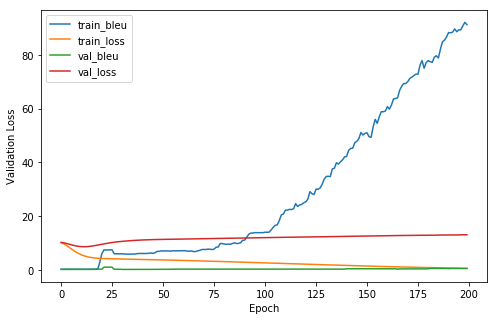

In [17]:
plot_single_learning_curve(results)

In [ ]:
# Epoch: 199.00, Train Loss: 0.32, Val Loss: 13.19, Train BLEU: 98.94, Val BLEU: 0.27
plot_single_learning_curve(results)

In [ ]:
# with attention energies = v_broadcast.bmm(torch.tanh(self.attn(concat)).transpose(1, 2)) # switched order  
# Epoch: 199.00, Train Loss: 0.63, Val Loss: 12.82, Train BLEU: 92.05, Val BLEU: 0.38
plot_single_learning_curve(results)

In [ ]:
for i, token in enumerate(vocab[SRC_LANG]['id2token']): 
    if i < 20: 
        print("{}: {}".format(i, token))

In [ ]:
for i, token in enumerate(vocab[TARG_LANG]['id2token']): 
    if i < 20: 
        print("{}: {}".format(i, token))

In [ ]:
import torch
x = torch.arange(0, 3*5*10).view(3, 5, 10)
print(x)
y = x[1:, :, :]
print(y)
z = y.view(-1, 10)
print(z)

In [ ]:
t = torch.arange(0, 2*5).view(5, 2)
print(t)
u = t.contiguous().view(-1)
print(u)
v = t.permute(1, 0)
print(v)
w = v.contiguous().view(-1)
print(w)

In [ ]:
a = torch.arange(0, 2*1*300)
print(a)
b = a.view(-1, 1, 300)
print(b.size())

In [ ]:
for i, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(full_loaders['train']):
#     print(i)
#     print(src_idxs.size())
#     print(src_idxs)
#     print(src_lens)
#     print(targ_idxs.size())
#     print(targ_idxs)
#     print(targ_lens)
    id2token = vocab[SRC_LANG]['id2token']
    test_tensor = src_idxs
    list_of_lists = test_tensor.numpy().astype(int).tolist()
    to_token = lambda l: ' '.join([id2token[idx] for idx in l])
    list_of_lists_tokens = [to_token(l) for l in list_of_lists] 
    break 